In [1]:
# Run training script
!export MODEL_NAME="runwayml/stable-diffusion-v1-5"
!export DATASET_NAME="./ryan_perkins"
!export OUTPUT_DIR="./out/03-07"

!accelerate launch --mixed_precision="fp16"  train_text_to_image_lora.py \
  --pretrained_model_name_or_path="runwayml/stable-diffusion-v1-5" \
  --dataset_name="lambdalabs/pokemon-blip-captions" \
  --dataloader_num_workers=8 \
  --resolution=512 --center_crop --random_flip \
  --train_batch_size=1 \
  --gradient_accumulation_steps=4 \
  --max_train_steps=15000 \
  --learning_rate=1e-04 \
  --max_grad_norm=1 \
  --lr_scheduler="cosine" --lr_warmup_steps=0 \
  --output_dir=$"./out/03-07" \
  --report_to=wandb \
  --checkpointing_steps=500 \
  --validation_prompt="A pokemon with blue eyes." \
  --seed=42

[2023-07-03 23:51:15,949] [INFO] [real_accelerator.py:110:get_accelerator] Setting ds_accelerator to cuda (auto detect)
[2023-07-03 23:51:18,292] [INFO] [real_accelerator.py:110:get_accelerator] Setting ds_accelerator to cuda (auto detect)
/home/ryan/miniconda3/envs/msc_diss/lib/python3.10/site-packages/accelerate/utils/dataclasses.py:589: UserWarning: DeepSpeed Zero3 Init flag is only applicable for ZeRO Stage 3. Setting it to False.
  warnings.warn("DeepSpeed Zero3 Init flag is only applicable for ZeRO Stage 3. Setting it to False.")
[2023-07-03 23:51:19,858] [WARNING] [comm.py:152:init_deepspeed_backend] NCCL backend in DeepSpeed not yet implemented
[2023-07-03 23:51:19,858] [INFO] [comm.py:594:init_distributed] cdb=None
[2023-07-03 23:51:19,858] [INFO] [comm.py:625:init_distributed] Initializing TorchBackend in DeepSpeed with backend nccl
07/03/2023 23:51:19 - INFO - __main__ - Distributed environment: DEEPSPEED  Backend: nccl
Num processes: 1
Process index: 0
Local process index: 

In [2]:
# Inference
import torch
from diffusers import StableDiffusionPipeline, DPMSolverMultistepScheduler

# Load model
model_base = "runwayml/stable-diffusion-v1-5"

# Set model to load fine-tuned weights
pipe = StableDiffusionPipeline.from_pretrained(model_base, torch_dtype=torch.float16)
pipe.scheduler = DPMSolverMultistepScheduler.from_config(pipe.scheduler.config)


[2023-07-05 11:07:21,927] [INFO] [real_accelerator.py:110:get_accelerator] Setting ds_accelerator to cuda (auto detect)


Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.


In [6]:
pipe.unet.load_attn_procs("./out/26-06")
pipe.to("cuda")

inf_out = "inference/05-06-spec-test/"

seeds = [0, 1, 42, 49, 55, 1337, 26000, 50000, 50101]

prompt = "spectrogram"

for seed in seeds:
    gen = torch.manual_seed(seed)
    
    # use half the weights from the LoRA finetuned model and half the weights from the base model
    image = pipe(
        prompt, num_inference_steps=25, guidance_scale=7.5, cross_attention_kwargs={"scale": 0}, generator=gen
    ).images[0]
    image.save(inf_out + prompt + "_" + str(seed) + "_base" + ".png")
    # use the weights from the fully finetuned LoRA model

    image = pipe(prompt, num_inference_steps=25, guidance_scale=7.5).images[0]
    image.save(inf_out + prompt + "_" + str(seed) + "_lora" + ".png")


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

In [4]:
import os
import matplotlib.pyplot as plt
from matplotlib.image import imread

def display_images_in_grid(folder_path):
    # Get a list of all image files in the folder
    image_files = [file for file in os.listdir(folder_path) if file.endswith(('.jpg', '.jpeg', '.png', '.gif'))]
    image_files.sort()  # Sort the image files in alphabetical order

    # Set up the grid layout
    num_images = len(image_files)
    num_cols = 2  # Number of columns in the grid
    num_rows = (num_images + num_cols - 1) // num_cols  # Number of rows based on the number of images

    # Create a figure and axis objects
    fig, axs = plt.subplots(num_rows, num_cols, figsize=(12, 8))
        # Adjust the spacing properties
    plt.subplots_adjust(wspace=0, hspace=0)

    # Iterate over the image files and display them in the grid
    for i, image_file in enumerate(image_files):
        # Compute the row and column index of the current image
        row = i // num_cols
        col = i % num_cols

        # Load the image using Matplotlib's imread
        image_path = os.path.join(folder_path, image_file)
        image = imread(image_path)

        # Display the image
        axs[row, col].imshow(image)
        axs[row, col].axis("off")

        # Set the filename as the title
        """ filename = os.path.splitext(image_file)[0]
        axs[row, col].set_title(filename, fontsize=8) """

    # Add column titles
    axs[0, 0].set_title("Base")
    axs[0, 1].set_title("LoRA")

    # Adjust the spacing and layout
    plt.tight_layout()

    # Show the grid of images
    plt.show()

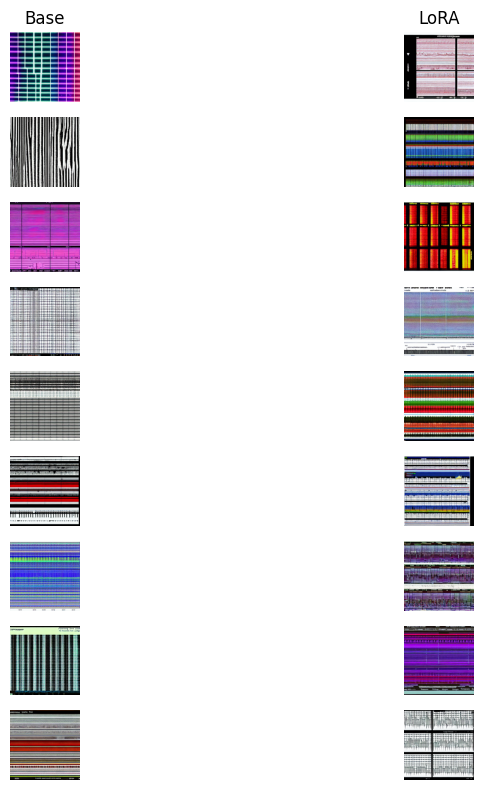

In [8]:
# Display inference

# Specify the folder path where the images are located
folder_path = "./inference/05-06-spec-test/"

# Call the function to display images in a grid
display_images_in_grid(folder_path)